Unravelling with the V-model with just one bath

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from _utils import *
from FCS import *

In [2]:
# Define system parameters
N = 3 # Number of levels
nu = 1 # Frequency of the system
# a = 0.1
# delta = 0.03
a = 0.02
delta = 0.001
# beta = 1/4 # Inverse temperature
beta = 1

# Define the parameters for the V-model
params = {'nu': nu, 'a': a, 'delta': delta, 'beta': beta}

# Set up the open system problem with one bath at temperature 1/beta
g_ops, H_uni, c_ops_uni = V_model_1bath(**params, kind='unified')
g_ops, H_sec, c_ops_sec = V_model_1bath(**params, kind='secular')

# Define the steady state density operators
rho_ss_uni = steadystate(H_uni, c_ops_uni)
rho_ss_sec = steadystate(H_sec, c_ops_sec)

In [3]:
# Calculate relevant timescales

tau1 = 1/(rates(a, nu, beta, kind='down')*(1+ np.exp(-beta*nu)))
tau2 = rates(a, nu, beta, kind='down')*(1 + np.exp(-beta*nu))/(delta**2*(1 + 2*np.exp(-beta*nu)))

print(tau1)
print(tau2)

23.105857863000484
24933.801990029886


In [36]:
# We want to unravel the master equation

t0, tf = 0, 300
dt = 0.01
tlist = np.arange(t0, tf, dt)
# tlist = np.logspace(-1, np.log10(tf), 10000)

g1, g2, g3 = g_ops

# Start the system in a pure state
# psi_init = (g2 + g3)/np.sqrt(2)
psi_init = g1
rho_init = psi_init*psi_init.dag()

# define observables 
e_ops = [g1*g1.dag(), g2*g2.dag(), g3*g3.dag(), g3*g2.dag()]

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni = photocurrent_mesolve(H_uni, rho_init, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=1, noise=2, store_measurement=True)
result_sec = photocurrent_mesolve(H_sec, rho_init, tlist, sc_ops=c_ops_sec, e_ops=e_ops, ntraj=1, noise=2, store_measurement=True)

Total run time:   0.33s
Total run time:   0.44s


In [37]:
# Get all the expectation values
g1_evo_uni = result_uni.expect[0]
g2_evo_uni = result_uni.expect[1]
g3_evo_uni = result_uni.expect[2]
g32_evo_uni = result_uni.expect[3]

g1_evo_sec = result_sec.expect[0]
g2_evo_sec = result_sec.expect[1]
g3_evo_sec = result_sec.expect[2]
g32_evo_sec = result_sec.expect[3]

In [38]:
# Analytic solution for the non-conditional coherence (from Felix's work)

k = a*nu*BoseEinsteinDistribution(nu,beta)
phi = k*(1 + 2*np.exp(-beta*nu))
tau = (2*k*(1+np.exp(-beta*nu)))/(delta**2*(1 + 2*np.exp(-beta*nu)))
g32_analytic = ((phi - k)/(2*(phi + k)))*(np.exp(-tlist/tau)-np.exp(-(phi + k)*tlist))


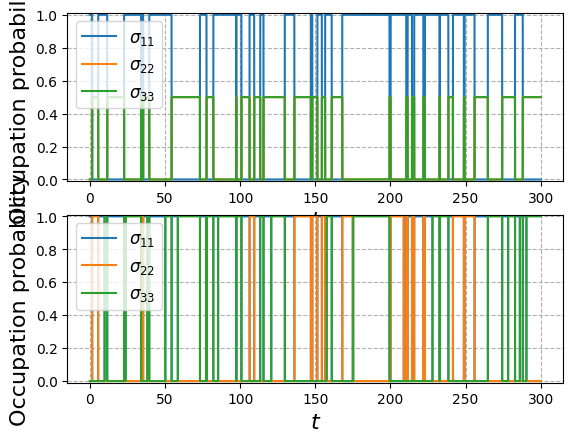

In [39]:
# Plot the populations

plt.subplot(211)
plt.plot(tlist, g1_evo_uni, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_uni, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_uni, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 1.01)

plt.subplot(212)

plt.plot(tlist, g1_evo_sec, label=r'$\sigma_{11}$')
plt.plot(tlist, g2_evo_sec, label=r'$\sigma_{22}$') 
plt.plot(tlist, g3_evo_sec, label=r'$\sigma_{33}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Occupation probability', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

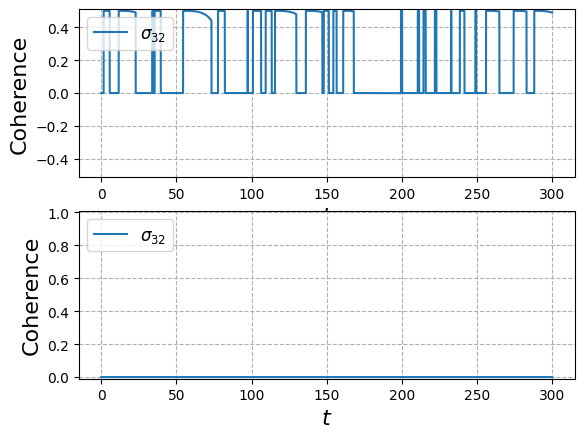

In [42]:
# Plot the coherences

plt.subplot(211)
plt.plot(tlist, g32_evo_uni, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.511, 0.51)

# plt.vlines([tau],-0.5,0.5,colors=['black'], linestyles=['--'])

plt.subplot(212)

plt.plot(tlist, g32_evo_sec, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 1.01)

plt.show()

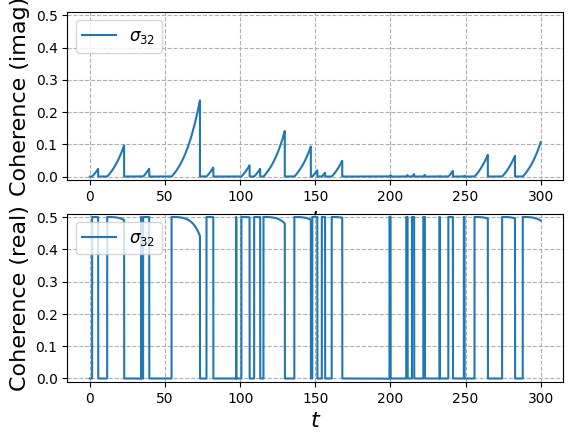

In [43]:
# plot the imaginary and real parts of the coherence side by side

plt.subplot(211)
plt.plot(tlist, g32_evo_uni.imag, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence (imag)', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.011, 0.51)

# plt.vlines([tau],-0.5,0.5,colors=['black'], linestyles=['--'])

plt.subplot(212)

plt.plot(tlist, g32_evo_uni.real, label=r'$\sigma_{32}$')

plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence (real)', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')

plt.ylim(-0.01, 0.51)

plt.show()

In [91]:
# Let's build the non-conditional density operator by averaging over an ensemble of trajectories, for comparison to the solution of the QME
# Unified only, we know the secular equation will give simple behaviour for the coherence

N = 100 # Number of trajectories in the ensemble

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_uni_ensemble = photocurrent_mesolve(H_uni, rho_init, tlist, sc_ops=c_ops_uni, e_ops=e_ops, ntraj=200, noise=13, store_measurement=True)

10.0%. Run time:   7.13s. Est. time left: 00:00:01:04
20.0%. Run time:  13.40s. Est. time left: 00:00:00:53
30.0%. Run time:  19.46s. Est. time left: 00:00:00:45
40.0%. Run time:  26.70s. Est. time left: 00:00:00:40
50.0%. Run time:  34.05s. Est. time left: 00:00:00:34
60.0%. Run time:  46.26s. Est. time left: 00:00:00:30
70.0%. Run time:  54.61s. Est. time left: 00:00:00:23
80.0%. Run time:  67.09s. Est. time left: 00:00:00:16
90.0%. Run time:  76.63s. Est. time left: 00:00:00:08
Total run time:  81.65s


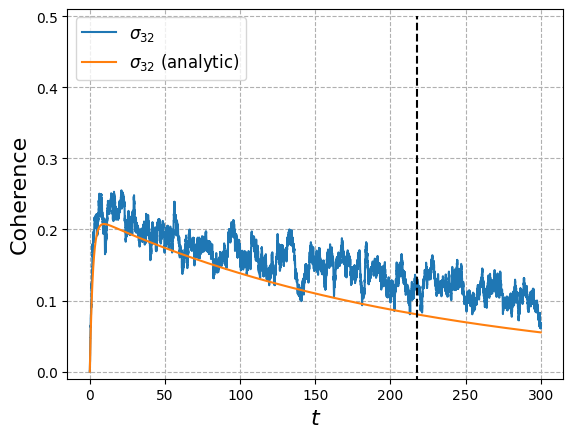

In [92]:
# Plot coherence for the ensemble
g32_evo_uni_ensemble = result_uni_ensemble.expect[3]

plt.figure()
plt.plot(tlist, g32_evo_uni_ensemble, label=r'$\sigma_{32}$')
plt.plot(tlist, g32_analytic, label=r'$\sigma_{32}$ (analytic)')
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel('Coherence', fontsize=16)
plt.legend(fontsize=12, loc="upper left")
plt.grid(linestyle='--')
plt.ylim(-0.01, 0.51)

plt.vlines([tau],-0.5,0.5,colors=['black'], linestyles=['--'])


plt.show()

Now we wish to transform to a new basis containing the ground state and the + and - superpositions of the two excited states $|\pm\rangle = \frac{1}{\sqrt{2}}(|2\rangle\pm|3\rangle)$. The transformation amounts to a 45 degree rotation in the subspace spanned by the excited states. $V=[[1,0,0],[0,1/\sqrt{2},-1/\sqrt{2}],[0,1/\sqrt{2},1/\sqrt{2}]]$

In [4]:
# Set up the open system problem with one bath at temperature 1/beta
g_ops, H_prime, c_ops_prime = V_model_1bath_uqme_transformed(**params)

# Define the steady state density operators
rho_ss_prime = steadystate(H_uni, c_ops_uni)

In [14]:
t0, tf = 0, 5000
dt = 0.05
tlist = np.arange(t0, tf, dt)
# tlist = np.logspace(-1, np.log10(tf), 10000)

g1, g2, g3 = g_ops

# Start the system in a pure state
psi_init = g1
rho_init = psi_init*psi_init.dag()

# define observables 
e_ops = [g1*g1.dag(), g2*g2.dag(), g3*g3.dag(), g3*g2.dag()]

# compute the solution, here the options ntraj is the number of trajectories and noise is the seed, store_measurement saves the jumps
result_prime = photocurrent_mesolve(H_prime, rho_init, tlist, sc_ops=c_ops_prime, e_ops=e_ops, ntraj=100, noise=2, store_measurement=True)

10.0%. Run time:   7.77s. Est. time left: 00:00:01:09
20.0%. Run time:  15.98s. Est. time left: 00:00:01:03
30.0%. Run time:  23.96s. Est. time left: 00:00:00:55
40.0%. Run time:  31.92s. Est. time left: 00:00:00:47
50.0%. Run time:  40.15s. Est. time left: 00:00:00:40
60.0%. Run time:  48.54s. Est. time left: 00:00:00:32
70.0%. Run time:  56.81s. Est. time left: 00:00:00:24
80.0%. Run time:  65.76s. Est. time left: 00:00:00:16
90.0%. Run time:  73.98s. Est. time left: 00:00:00:08
Total run time:  82.14s


In [15]:
# Get all the expectation values
g1_evo_prime = result_prime.expect[0]
g2_evo_prime = result_prime.expect[1]
g3_evo_prime = result_prime.expect[2]
g32_evo_prime = result_prime.expect[3]

(-0.01, 1.01)

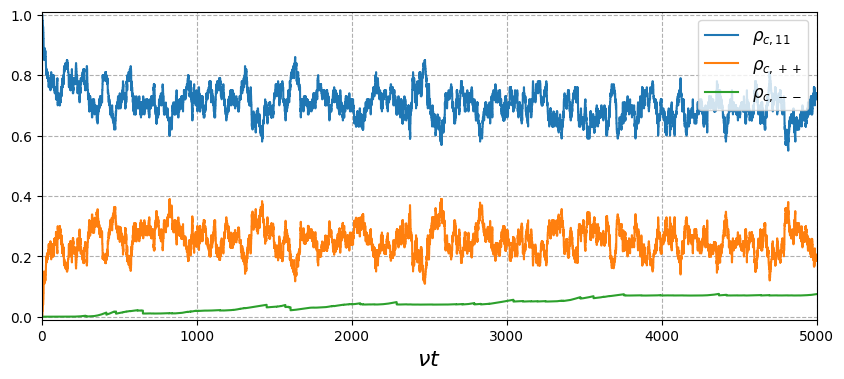

In [16]:
# Plot the populations
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(tlist, g1_evo_prime, label=r"$\rho_{c,11}$") 
ax1.plot(tlist, g2_evo_prime, label=r"$\rho_{c,++}$")
ax1.plot(tlist, g3_evo_prime, label=r"$\rho_{c,--}$")

ax1.set_xlabel(r'$\nu t$', fontsize=16)
# ax1.set_ylabel("Population")
plt.legend(fontsize=12, loc="upper right")
ax1.grid(linestyle='--')
# ax1.vlines(tau2, ymin=0, ymax=1, linestyles=['--'], colors=['k'])
ax1.set_xlim([t0,tf])
ax1.set_ylim(-0.01, 1.01)


(0.0, 5000.0)

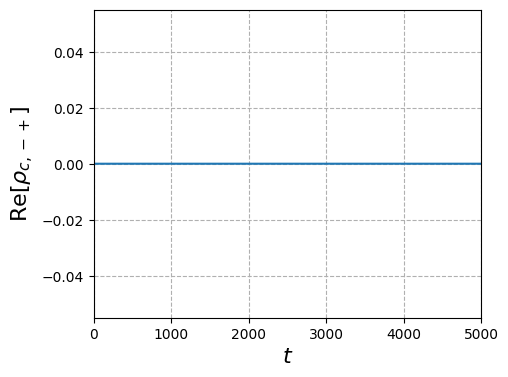

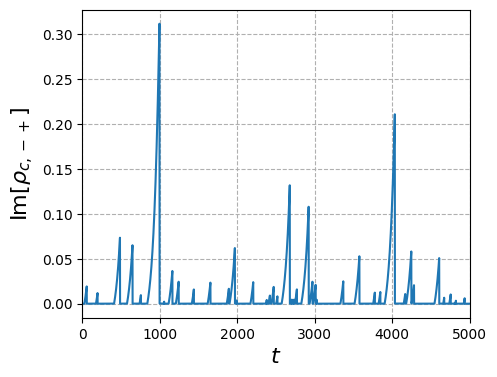

In [8]:
# Plot the coherences, real and imaginary

fig, ax1 = plt.subplots(figsize=(5,4))
ax1.plot(tlist, g32_evo_prime.real)#, label=r"Re[$\rho_{c,10}$]")

ax1.set_xlabel(r'$t$', fontsize=16)
ax1.set_ylabel(r"Re[$\rho_{c,-+}$]", fontsize=16)
# ax1.legend(fontsize=12, loc="upper left")
ax1.grid(linestyle='--')
ax1.set_xlim(t0,tf)
# ax1.set_ylim(-0.5, 0.5)

fig2, ax2 = plt.subplots(figsize=(5,4))
ax2.plot(tlist, g32_evo_prime.imag)#, label=r"Re[$\rho_{c,10}$]")

ax2.set_xlabel(r'$t$', fontsize=16)
ax2.set_ylabel(r"Im[$\rho_{c,-+}$]", fontsize=16)
# ax1.legend(fontsize=12, loc="upper left")
ax2.grid(linestyle='--')
ax2.set_xlim(t0,tf)
# ax1.set_ylim(-0.5, 0.5)